# Zarr Tutorial for Research Project
#### Difference between Zarr and XArray is Xarray is a computation library, and Zarr basically is a data structure for arrays, it does not have much computation functions

In [2]:
import numpy as np

In [3]:
print(np)

<module 'numpy' from '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/__init__.py'>


Creating an array:

In [6]:
a = np.zeros(shape=(10, 20), dtype='f8')
a.shape, a.dtype

((10, 20), dtype('float64'))

How much memory does the array use?

In [7]:
a.nbytes

1600

Getting a piece of data using slicing:

In [8]:
a[:2, :2]

array([[0., 0.],
       [0., 0.]])

In [9]:
a

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

In [10]:
a[:2]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

Create a new array and assign to it:

In [11]:
b = np.ones(shape=(40, 50), dtype='f8')
b[:10, :20] = a

In [12]:
b[0, 0]

0.0

In [13]:
b[-1, -1]

1.0

### A Zarr has four important properties:
1. Shape
2. Dtype
3. Chunks
4. Attributes

In [2]:
import zarr
z = zarr.create(shape=(40,50), dtype='f8', chunks=(10,10), store='test.zarr')


ContainsArrayError: path '' contains an array

In [17]:
z.info

Type,zarr.core.Array
Data type,float64
Shape,"(40, 50)"
Chunk shape,"(10, 10)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,16000 (15.6K)
No. bytes stored,337
Storage ratio,47.5


In [20]:
z.fill_value

0.0

### This is how we assign data to an array. When we do this it gets written immediately

In [21]:
z[:] = 1

In [22]:
z.info

Type,zarr.core.Array
Data type,float64
Shape,"(40, 50)"
Chunk shape,"(10, 10)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,16000 (15.6K)
No. bytes stored,1277 (1.2K)
Storage ratio,12.5


## Attributes
We can attach arbitrary metadata to our array via attributes

In [23]:
z.attrs['units'] = 'm/s'

In [24]:
dict(z.attrs)

{'units': 'm/s'}

## Under the hood
Where / how is our data actually stored? Lets look under the hood. The ability to look inside a Zarr store and understand what is there is a deliberate design decision

In [26]:
z.store

In [27]:
!tree -a test.zarr | head

zsh:1: command not found: tree


#### Using the store parameter, zarr directory is created and it contains multiple files. One of them is zarray file which is a json file and contains all the necessary information that is required the build the array from scratch

In [28]:
import json
with open('test.zarr/.zarray') as fp:
    display(json.load(fp))

{'chunks': [10, 10],
 'compressor': {'blocksize': 0,
  'clevel': 5,
  'cname': 'lz4',
  'id': 'blosc',
  'shuffle': 1},
 'dtype': '<f8',
 'fill_value': 0.0,
 'filters': None,
 'order': 'C',
 'shape': [40, 50],
 'zarr_format': 2}

#### Lets look at the metadata file present inside the directory

In [29]:
import json
with open('test.zarr/.zattrs') as fp:
    display(json.load(fp))

{'units': 'm/s'}

## Choosing Chunks
#### The main parameter we control when creating Zarr Arrays is the chunk shape. When selecting chunks, we need to keep in mind two constraints:
#### 1. Writes can be concurrent (come from different processes simultaneously) if they do not touch the same chunks. Yhis enables massively parallel writing in the cloud.
#### 2. When reading data, if any piece of the chunk is needed, the entire chunk has to be loaded. (This will be relaxed in Zarr V3.)

#### Here we will compare two different chunking strategies:

In [35]:
c = zarr.create(shape=(200, 200, 200), chunks=(1, 200, 200), dtype='f8', store='c.zarr') 

ContainsArrayError: path '' contains an array

In [42]:
import xarray as xr
import hvplot.xarray

ds = xr.tutorial.open_dataset('air_temperature')
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

## Writing Zarr from Zarray
### First we chunk the dataset. This accomplishes two things
- Allows parallel processing using Dask(Not necessary for this small-data example but very useful for big data)
- Automatically maps Dash chunks to Zarr chunks when writing

## Problem Statement:
- Inputs are Outputs are multi dimensional
- Data are larger than memory
- Computation can be parallelised.
- I/O is the bottleneck.
- Data are compressible.
- Speed matters

## Solution:
- Chunked parallel tensor computing framework.
- Chunked, parallel tensor storage library.
- Align the chunks corresponding to the chunks.

In [1]:
zarr.__version__

NameError: name 'zarr' is not defined

In [2]:
tree -a test.zarr

SyntaxError: invalid syntax (3274838301.py, line 1)

In [1]:
hello = root.zeros('hello', 
                  shape=(10,10),
                  chunks=(2,2),
                  dtype='<i4>')

NameError: name 'root' is not defined

## Creating an array

In [4]:
import zarr
store = zarr.DirectoryStore('example.zarr')
root = zarr.group(store)
root

<zarr.hierarchy.Group '/'>

In [5]:
import zarr
z = zarr.zeros((10,10), chunks=(5,5), dtype='i4')
z

<zarr.core.Array (10, 10) int32>

In [1]:
import xarray as xr
nc_data = xr.open_dataset("/Users/sagnik/Documents/Research Project/download.nc")
nc_data

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 4)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2020-04-17 ... 2020-04-17T03:00:00
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    lsm        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-02 19:37:09 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

## Converting a netcdf data to Zarr array

In [18]:
import zarr
zarr_data = zarr.array(nc_data.to_dataarray(), chunks=(10, 10, 100, 100))
zarr_data

<zarr.core.Array (3, 4, 721, 1440) float32>

In [19]:
zarr_data.info


Type,zarr.core.Array
Data type,float32
Shape,"(3, 4, 721, 1440)"
Chunk shape,"(10, 10, 100, 100)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.KVStore
No. bytes,49835520 (47.5M)
No. bytes stored,29693211 (28.3M)
Storage ratio,1.7


In [7]:
zarr_data.dimension

AttributeError: 'Array' object has no attribute 'dimension'

In [8]:
zarr_data.dims

AttributeError: 'Array' object has no attribute 'dims'

In [9]:
nc_data.dims

Frozen({'longitude': 1440, 'latitude': 721, 'time': 4})

In [10]:
nc_data.dims.count


AttributeError: 'Frozen' object has no attribute 'count'

In [12]:
nc_data.dims[1]

KeyError: 1

In [13]:
nc_data.todataarray

AttributeError: 'Dataset' object has no attribute 'todataarray'

In [15]:
nc_data.to_dataarray().dims[0]

'variable'

In [20]:
root.tree()

NameError: name 'root' is not defined

In [21]:
import xarray as xr
nc_data = xr.open_dataset("/Users/sagnik/Documents/Research Project/download.nc")
nc_data

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 4)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2020-04-17 ... 2020-04-17T03:00:00
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    lsm        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-02 19:37:09 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [24]:
nc_data.sel(longitude=0.0) #Dropping the data that has a different longitudenc_data

<xarray.Dataset>
Dimensions:    (latitude: 721, time: 4)
Coordinates:
    longitude  float32 0.0
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2020-04-17 ... 2020-04-17T03:00:00
Data variables:
    u10        (time, latitude) float32 ...
    v10        (time, latitude) float32 ...
    lsm        (time, latitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-02 19:37:09 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [25]:
nc_data.sel(longitude=0.0, latitude=90.0)

<xarray.Dataset>
Dimensions:    (time: 4)
Coordinates:
    longitude  float32 0.0
    latitude   float32 90.0
  * time       (time) datetime64[ns] 2020-04-17 ... 2020-04-17T03:00:00
Data variables:
    u10        (time) float32 ...
    v10        (time) float32 ...
    lsm        (time) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-02 19:37:09 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [26]:
nc_data.sel(longitude=0.0, latitude=90.0, time='2020-04-17T00:00:00.000000000')

<xarray.Dataset>
Dimensions:    ()
Coordinates:
    longitude  float32 0.0
    latitude   float32 90.0
    time       datetime64[ns] 2020-04-17
Data variables:
    u10        float32 ...
    v10        float32 ...
    lsm        float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-02 19:37:09 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [30]:
nc_data.sel(longitude=3.0, latitude=4.0, method='nearest') #the nearest funtion retrieves the nearest value of the parameters if not present

<xarray.Dataset>
Dimensions:    (time: 4)
Coordinates:
    longitude  float32 3.0
    latitude   float32 4.0
  * time       (time) datetime64[ns] 2020-04-17 ... 2020-04-17T03:00:00
Data variables:
    u10        (time) float32 ...
    v10        (time) float32 ...
    lsm        (time) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-02 19:37:09 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [32]:
nc_data.sel(latitude=[-16, -15], longitude=[-46, -47], method='nearest')

<xarray.Dataset>
Dimensions:    (longitude: 2, latitude: 2, time: 4)
Coordinates:
  * longitude  (longitude) float32 0.0 0.0
  * latitude   (latitude) float32 -16.0 -15.0
  * time       (time) datetime64[ns] 2020-04-17 ... 2020-04-17T03:00:00
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    lsm        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-02 19:37:09 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [34]:
#Writing query to filter values in the dataset

QUERY = nc_data.longitude < 64
QUERY = QUERY & (nc_data.latitude > -8)

nc_data.where(QUERY, drop=True)

<xarray.Dataset>
Dimensions:    (time: 4, latitude: 392, longitude: 256)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 63.0 63.25 63.5 63.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -7.25 -7.5 -7.75
  * time       (time) datetime64[ns] 2020-04-17 ... 2020-04-17T03:00:00
Data variables:
    u10        (time, latitude, longitude) float32 0.2035 0.2035 ... 3.614 3.867
    v10        (time, latitude, longitude) float32 0.2515 0.2515 ... -1.242
    lsm        (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-02 19:37:09 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

(array([2.041000e+03, 3.885300e+04, 2.453250e+05, 7.737040e+05,
        1.625434e+06, 9.877870e+05, 3.590030e+05, 1.079040e+05,
        1.206500e+04, 8.440000e+02]),
 array([-20.40168762, -15.98624229, -11.57079792,  -7.15535259,
         -2.73990774,   1.67553711,   6.09098196,  10.50642681,
         14.92187214,  19.33731651,  23.75276184]),
 <BarContainer object of 10 artists>)

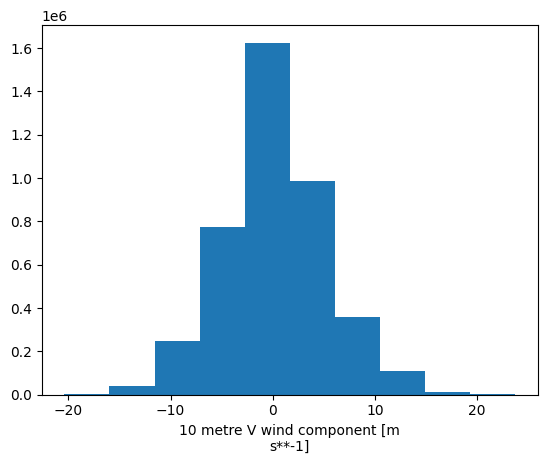

In [35]:
nc_data.v10.plot()

In [36]:
nc_data.v10

<xarray.DataArray 'v10' (time: 4, latitude: 721, longitude: 1440)>
[4152960 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2020-04-17 ... 2020-04-17T03:00:00
Attributes:
    units:      m s**-1
    long_name:  10 metre V wind component

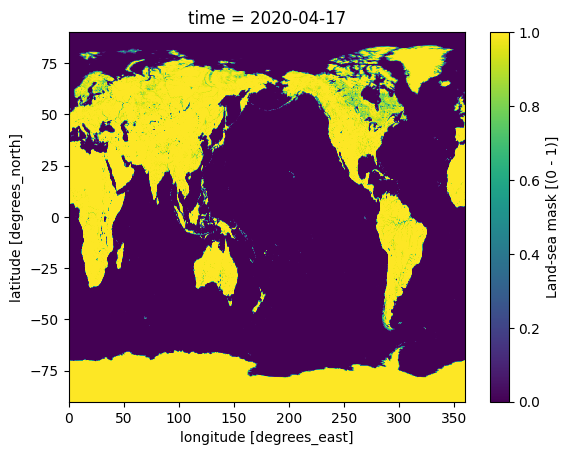

In [38]:
nc_data.isel(time=0).lsm.plot() #Plotting the lsm value at time stamp = 0. ) 0 represents sea and 1 represents land

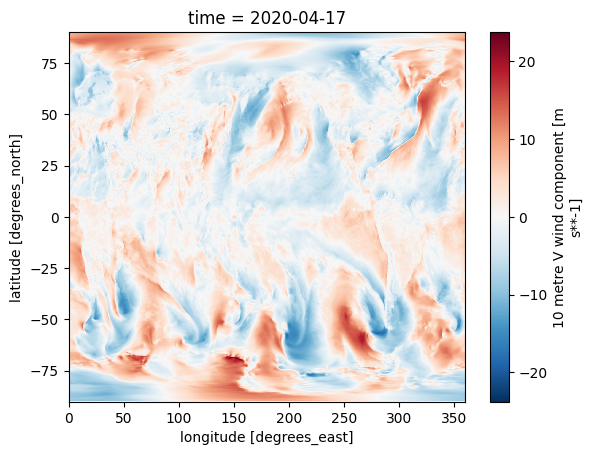

In [40]:
nc_data.isel(time=0).v10.plot()

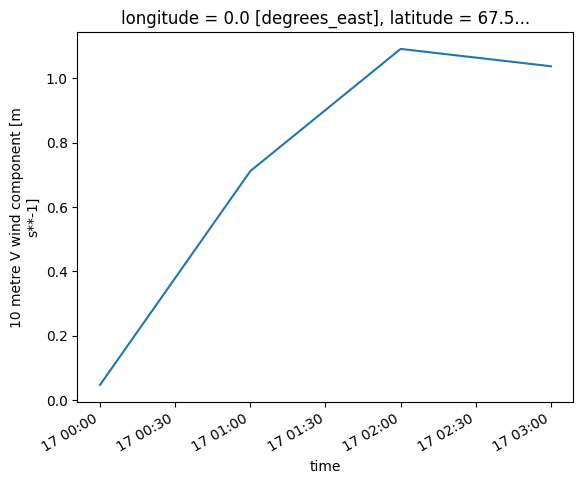

In [47]:
nc_data.isel(longitude=0, latitude=90).v10.plot()

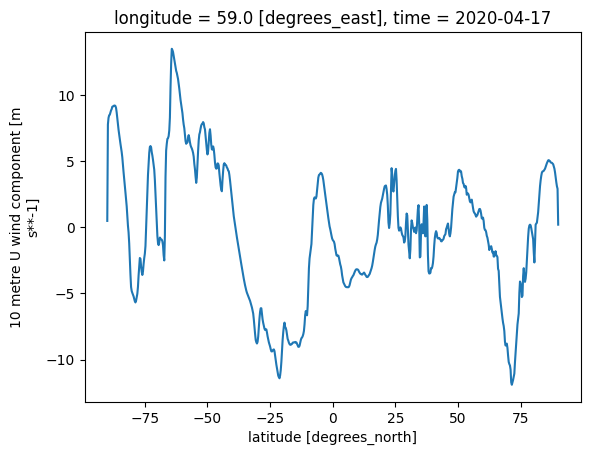

In [53]:
nc_data.isel(time=0).sel(longitude=59, method='nearest').u10.plot()

### Apply simple operations over multidimensional data

In [56]:
nc_data.u10.mean() #simpel aggregation function

<xarray.DataArray 'u10' ()>
array(0.35170415, dtype=float32)

In [55]:
nc_data.v10.mean()

<xarray.DataArray 'v10' ()>
array(0.22488436, dtype=float32)

In [57]:
nc_data.lsm.mean()

<xarray.DataArray 'lsm' ()>
array(0.33589736, dtype=float32)

In [58]:
mean_horizontal_wind = nc_data.u10.mean(dim='time')
mean_horizontal_wind

<xarray.DataArray 'u10' (latitude: 721, longitude: 1440)>
array([[ 0.28716603,  0.28716603,  0.28716603, ...,  0.28716603,
         0.28716603,  0.28716603],
       [-7.8989534 , -7.8777924 , -7.8567934 , ..., -7.9452133 ,
        -7.9301214 , -7.914374  ],
       [-7.9837646 , -7.957517  , -7.922084  , ..., -8.05988   ,
        -8.029696  , -8.0036125 ],
       ...,
       [-2.5904922 , -2.5717914 , -2.5419352 , ..., -2.6667726 ,
        -2.6347845 , -2.6090293 ],
       [-2.1782498 , -2.159221  , -2.1395357 , ..., -2.2284474 ,
        -2.2115507 , -2.1948183 ],
       [ 0.48828387,  0.48828387,  0.48828387, ...,  0.48828387,
         0.48828387,  0.48828387]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0

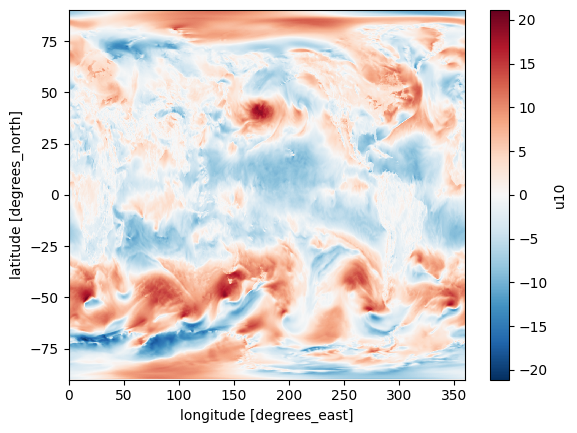

In [59]:
mean_horizontal_wind.plot()

In [60]:
mean_vertical_wind = nc_data.v10.mean(dim='time')
mean_vertical_wind

<xarray.DataArray 'v10' (latitude: 721, longitude: 1440)>
array([[ 0.1708307,  0.1708307,  0.1708307, ...,  0.1708307,  0.1708307,
         0.1708307],
       [ 8.08633  ,  8.10267  ,  8.119514 , ...,  8.021481 ,  8.043209 ,
         8.064602 ],
       [ 8.3477545,  8.370832 ,  8.399973 , ...,  8.240963 ,  8.28341  ,
         8.319456 ],
       ...,
       [-8.750278 , -8.757015 , -8.766617 , ..., -8.709514 , -8.7272005,
        -8.74135  ],
       [-9.341346 , -9.347073 , -9.3528   , ..., -9.313384 , -9.32248  ,
        -9.332418 ],
       [-0.0622952, -0.0622952, -0.0622952, ..., -0.0622952, -0.0622952,
        -0.0622952]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0

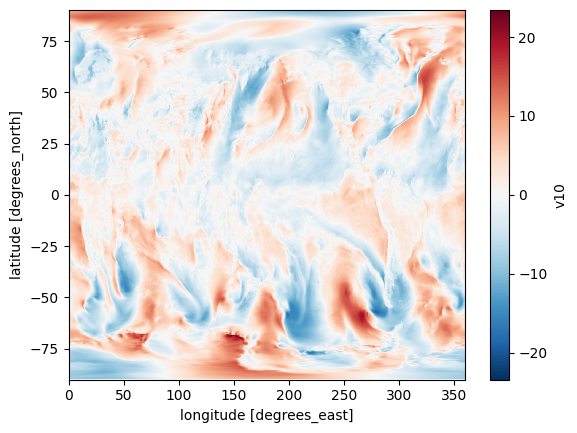

In [61]:
mean_vertical_wind.plot()

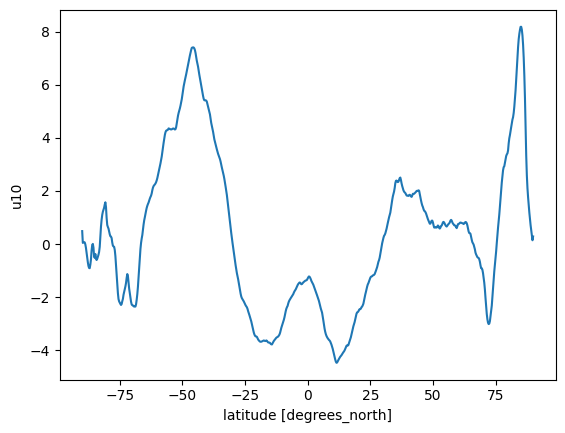

In [63]:
nc_data.u10.mean(dim=['time', 'longitude']).plot()

(array([2664988.,   25884.,   19892.,   17560.,   17244.,   17196.,
          19676.,   27080.,   51744., 1291696.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

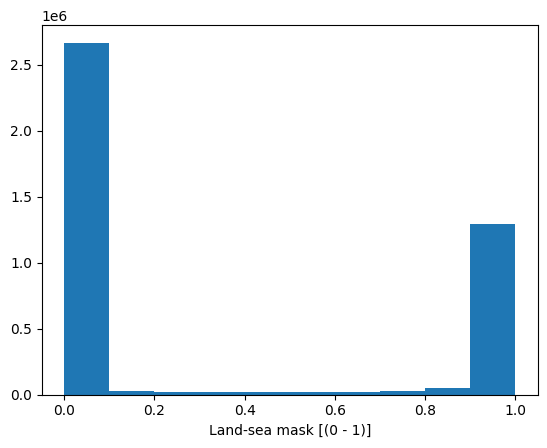

In [64]:
nc_data.lsm.plot()

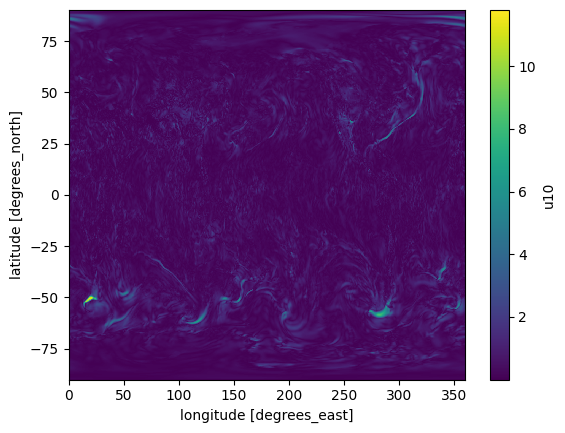

In [65]:
nc_data.u10.std(dim='time').plot()

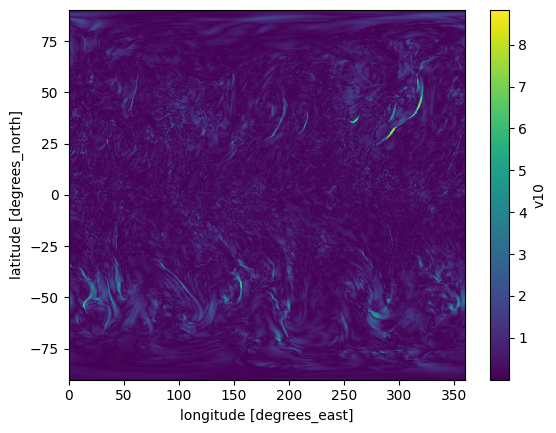

In [66]:
nc_data.v10.std(dim='time').plot()

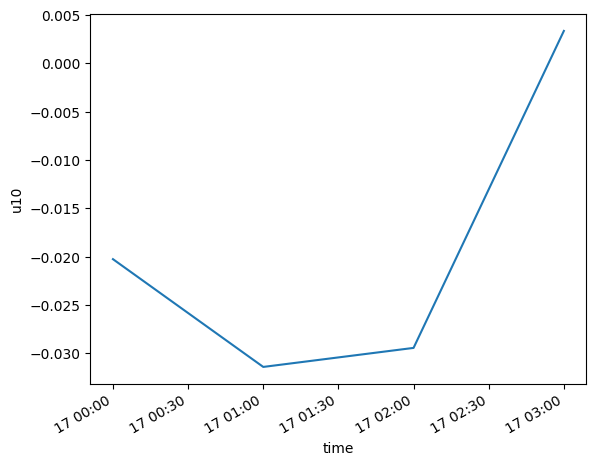

In [67]:
nc_data.u10.median(dim=['longitude', 'latitude']).plot()

### Apply group operations over multi dimensional data

In [72]:
(nc_data.groupby(nc_data.time.dt.year)
    .mean(dim=['time', 'latitude', 'longitude'])
    .u10
    .plot()) #this is not going to work since we dont have the required data. Can use 'month' instead of 'year'

TypeError: No numeric data to plot.

### Merge and Contacetante datasets

In [73]:
nc_data.time.dt.year

<xarray.DataArray 'year' (time: 4)>
array([2020, 2020, 2020, 2020])
Coordinates:
  * time     (time) datetime64[ns] 2020-04-17 ... 2020-04-17T03:00:00
Attributes:
    long_name:  time

In [74]:
da = nc_data.longitude ** 2 + nc_data.latitude ** 2
da.name = 'squared_distance'

nc_data_2 = nc_data.merge(da)
nc_data_2

<xarray.Dataset>
Dimensions:           (longitude: 1440, latitude: 721, time: 4)
Coordinates:
  * longitude         (longitude) float32 0.0 0.25 0.5 ... 359.2 359.5 359.8
  * latitude          (latitude) float32 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time              (time) datetime64[ns] 2020-04-17 ... 2020-04-17T03:00:00
Data variables:
    u10               (time, latitude, longitude) float32 0.2035 ... 0.5119
    v10               (time, latitude, longitude) float32 0.2515 ... -0.05236
    lsm               (time, latitude, longitude) float32 0.0 0.0 ... 1.0 1.0
    squared_distance  (longitude, latitude) float32 8.1e+03 ... 1.375e+05
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-02 19:37:09 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [75]:
nc_data_squared_root = nc_data ** (1/2)
nc_data_cubed_root = nc_data ** (1/3)
nc_data_4 = xr.concat([nc_data, nc_data_squared_root, nc_data_cubed_root], 'dim_power')
nc_data_4

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 4, dim_power: 3)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2020-04-17 ... 2020-04-17T03:00:00
Dimensions without coordinates: dim_power
Data variables:
    u10        (dim_power, time, latitude, longitude) float32 0.2035 ... 0.8
    v10        (dim_power, time, latitude, longitude) float32 0.2515 ... nan
    lsm        (dim_power, time, latitude, longitude) float32 0.0 0.0 ... 1.0
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-02 19:37:09 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

### Interact with pandas and export datasets

In [76]:
df = nc_data.to_dataframe()
df

u10       v10  lsm
longitude latitude time                                        
0.00       90.00   2020-04-17 00:00:00  0.203504  0.251515  0.0
                   2020-04-17 01:00:00  0.255342  0.218500  0.0
                   2020-04-17 02:00:00  0.341957  0.171336  0.0
                   2020-04-17 03:00:00  0.347862  0.041971  0.0
           89.75   2020-04-17 00:00:00 -7.322831  7.678529  0.0
...                                          ...       ...  ...
359.75    -89.75   2020-04-17 03:00:00 -1.938910 -9.122706  1.0
          -90.00   2020-04-17 00:00:00  0.487628 -0.044272  1.0
                   2020-04-17 01:00:00  0.465318 -0.072570  1.0
                   2020-04-17 02:00:00  0.488284 -0.079982  1.0
                   2020-04-17 03:00:00  0.511906 -0.052357  1.0

[4152960 rows x 3 columns]

In [77]:
da = nc_data.time.dt.month
da.to_dataframe()

,month
time,
2020-04-17 00:00:00,4
2020-04-17 01:00:00,4
2020-04-17 02:00:00,4
2020-04-17 03:00:00,4


In [78]:
da.to_series()

time
2020-04-17 00:00:00    4
2020-04-17 01:00:00    4
2020-04-17 02:00:00    4
2020-04-17 03:00:00    4
Name: month, dtype: int64

In [79]:
xr.Dataset.from_dataframe(df)

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 4)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2020-04-17 ... 2020-04-17T03:00:00
Data variables:
    u10        (longitude, latitude, time) float32 0.2035 0.2553 ... 0.5119
    v10        (longitude, latitude, time) float32 0.2515 0.2185 ... -0.05236
    lsm        (longitude, latitude, time) float32 0.0 0.0 0.0 ... 1.0 1.0 1.0

In [80]:
xr.DataArray.from_series(df.u10)

<xarray.DataArray 'u10' (longitude: 1440, latitude: 721, time: 4)>
array([[[ 0.20350364,  0.2553415 ,  0.34195668,  0.34786227],
        [-7.322831  , -7.5675845 , -8.024283  , -8.681115  ],
        [-7.2939596 , -7.6036744 , -8.251976  , -8.785447  ],
        ...,
        [-2.7985    , -2.6659524 , -2.5261872 , -2.3713295 ],
        [-2.4257922 , -2.2689662 , -2.0957358 , -1.9225054 ],
        [ 0.48762769,  0.46531773,  0.48828387,  0.51190615]],

       [[ 0.20350364,  0.2553415 ,  0.34195668,  0.34786227],
        [-7.303146  , -7.547243  , -8.003285  , -8.657493  ],
        [-7.270337  , -7.5780835 , -8.224417  , -8.757231  ],
        ...,
        [-2.7788148 , -2.6475797 , -2.5078142 , -2.3529568 ],
        [-2.406107  , -2.249281  , -2.077363  , -1.9041326 ],
        [ 0.48762769,  0.46531773,  0.48828387,  0.51190615]],

       [[ 0.20350364,  0.2553415 ,  0.34195668,  0.34786227],
        [-7.2841167 , -7.5269017 , -7.9816313 , -8.634526  ],
        [-7.2388406 , -7.5439625 , -8.188327  , -8.717204  ],
        ...,
...
        [-2.8765848 , -2.7427251 , -2.6016474 , -2.4461336 ],
        [-2.476974  , -2.3188355 , -2.145605  , -1.9723749 ],
        [ 0.48762769,  0.46531773,  0.48828387,  0.51190615]],

       [[ 0.20350364,  0.2553415 ,  0.34195668,  0.34786227],
        [-7.3503904 , -7.597769  , -8.055779  , -8.716548  ],
        [-7.3346424 , -7.6476383 , -8.297908  , -8.838597  ],
        ...,
        [-2.8444324 , -2.7099164 , -2.5701509 , -2.4146373 ],
        [-2.4599133 , -2.301775  , -2.1292007 , -1.9553142 ],
        [ 0.48762769,  0.46531773,  0.48828387,  0.51190615]],

       [[ 0.20350364,  0.2553415 ,  0.34195668,  0.34786227],
        [-7.336611  , -7.5820208 , -8.040031  , -8.698832  ],
        [-7.31102   , -7.6220474 , -8.272317  , -8.809069  ],
        ...,
        [-2.8168728 , -2.6849816 , -2.545216  , -2.3890464 ],
        [-2.4428527 , -2.2853706 , -2.1121402 , -1.9389098 ],
        [ 0.48762769,  0.46531773,  0.48828387,  0.51190615]]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2020-04-17 ... 2020-04-17T03:00:00

### Exporting dataset so that our changes are not removed

In [81]:
nc_data.to_netcdf('export.nc')

## Check the following requirements in Zarr:
1. Create an empty Zarr file with basic configurations.
2. How to create multi dimensional data and apply configurations on it.
3. Write queries to read the data.
4. Now check the benchmarking implementation to compare the configurations.
5. Read a netcdf data.
6. Now apply the checked configurations on the data,
7. Now benchmark the configuration on the relatively large dataset.

### 1. Creating a basic Zarr file with basic configurations.

In [6]:
import zarr
z = zarr.zeros((10, 10), chunks=(2, 2), dtype='i4')
z

<zarr.core.Array (10, 10) int32>

In [4]:
pip freeze

anyio==4.1.0
appnope==0.1.3
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asciitree==0.3.3
asttokens==2.4.1
async-lru==2.0.4
attrs==23.1.0
Babel==2.13.1
beautifulsoup4==4.12.2
bleach==6.1.0
bokeh==3.3.2
certifi==2023.11.17
cffi==1.16.0
cftime==1.6.3
charset-normalizer==3.3.2
colorcet==3.0.1
comm==0.2.0
contourpy==1.2.0
cycler==0.12.1
debugpy==1.8.0
decorator==5.1.1
defusedxml==0.7.1
executing==2.0.1
fasteners==0.19
fastjsonschema==2.19.0
fonttools==4.46.0
fqdn==1.5.1
holoviews==1.18.1
hvplot==0.9.0
idna==3.6
ipykernel==6.27.1
ipython==8.18.1
ipywidgets==8.1.1
isoduration==20.11.0
jedi==0.19.1
Jinja2==3.1.2
json5==0.9.14
jsonpointer==2.4
jsonschema==4.20.0
jsonschema-specifications==2023.11.2
jupyter==1.0.0
jupyter-console==6.6.3
jupyter-events==0.9.0
jupyter-lsp==2.2.1
jupyter_client==8.6.0
jupyter_core==5.5.0
jupyter_server==2.11.1
jupyter_server_terminals==0.4.4
jupyterlab==4.0.9
jupyterlab-widgets==3.0.9
jupyterlab_pygments==0.3.0
jupyterlab_server==2.25.2
kiwisolver

In [8]:
z.info

Type,zarr.core.Array
Data type,int32
Shape,"(10, 10)"
Chunk shape,"(2, 2)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.KVStore
No. bytes,400
No. bytes stored,333
Storage ratio,1.2


In [9]:
z[:]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [10]:
latest_zarr = zarr.create((10, 10), chunks=(2,2))
latest_zarr

<zarr.core.Array (10, 10) float64>

In [11]:
z[:]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [6]:
latest_zarr = zarr.create((2,2,2), chunks=(1, 1, 1))
latest_zarr

<zarr.core.Array (2, 2, 2) float64>

In [18]:
type(latest_zarr.store)

zarr.storage.KVStore

In [15]:
latest_zarr.chunks

(1, 1, 1)

In [16]:
latest_zarr.shape

(2, 2, 2)

In [17]:
latest_zarr[:]

array([[[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]]])

In [22]:
zarr1 = zarr.create((3, 3, 2), chunks=(1,1))
zarr1

<zarr.core.Array (3, 3, 2) float64>

In [23]:
zarr1[:]

array([[[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]]])

In [32]:
zarr1 = zarr.create((2, 1, 1), chunks=(1,1))
zarr1

<zarr.core.Array (2, 1, 1) float64>

In [33]:
zarr1[:]

array([[[0.]],

       [[0.]]])

In [34]:
import numpy as np

# Specify the dimensions of the 3D array
dimensions = (2, 3, 4)  # For example, a 2x3x4 array

# Initialize a 3D array with zeros
array_zeros = np.zeros(dimensions)

# Initialize a 3D array with ones
array_ones = np.ones(dimensions)

# Initialize a 3D array with random values
array_random = np.random.random(dimensions)

# Alternatively, you can create an array with a specific value
value = 42
array_custom_value = np.full(dimensions, value)

# Display the initialized arrays
print("Array of zeros:\n", array_zeros)
print("\nArray of ones:\n", array_ones)
print("\nArray of random values:\n", array_random)
print("\nArray with a custom value:\n", array_custom_value)


Array of zeros:
 [[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]

Array of ones:
 [[[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]]

Array of random values:
 [[[0.88504519 0.13363614 0.01994723 0.88598057]
  [0.38198864 0.41188024 0.47011578 0.73632754]
  [0.52124187 0.03848156 0.29444137 0.82119961]]

 [[0.4126182  0.76319354 0.55513213 0.29719287]
  [0.12204695 0.38855996 0.38899451 0.99003205]
  [0.15414724 0.96735692 0.26666258 0.55522192]]]

Array with a custom value:
 [[[42 42 42 42]
  [42 42 42 42]
  [42 42 42 42]]

 [[42 42 42 42]
  [42 42 42 42]
  [42 42 42 42]]]


In [37]:
array_random[1][2][3]

0.5552219202880708

### Chunking strategies---Benchmarking

In [19]:
import zarr
import time
zarr2 = zarr.create((1000, 1000, 1000), chunks=(100, 100, 100)) #chunks with shape 100,100,100 is created for the 3d array
zarr2.chunks

(100, 100, 100)

In [20]:
start_time = time.perf_counter()
zarr2[:]
end_time = time.perf_counter()
print("Read Time: ",end_time - start_time, "seconds")
start_time = time.perf_counter()
zarr2[:] = 1
end_time = time.perf_counter()
print("Write Time: ",end_time - start_time, "seconds")

Read Time:  2.588334625121206 seconds
Write Time:  1.748467667028308 seconds


In [7]:
import zarr
import time
zarr3 = zarr.create((1000, 1000, 1000), chunks=(50, 50, 50)) #chunks with shape 50,50,50 is created for the 3d array
zarr3.chunks

(50, 50, 50)

In [21]:
start_time = time.perf_counter()
zarr3[:]
end_time = time.perf_counter()
print("Read Time: ",end_time - start_time, "seconds")
start_time = time.perf_counter()
zarr3[:] = 1
end_time = time.perf_counter()
print("Write Time: ",end_time - start_time, "seconds")

Read Time:  1.9123466671444476 seconds
Write Time:  3.6060113341081887 seconds


In [23]:
import zarr
import time
zarr4 = zarr.create((1000, 1000, 1000), chunks=(50, None, None)) #chunks along the first dimension
zarr4.chunks

(50, 1000, 1000)

In [24]:
start_time = time.perf_counter()
zarr4[:]
end_time = time.perf_counter()
print("Read Time: ",end_time - start_time, "seconds")
start_time = time.perf_counter()
zarr4[:] = 1
end_time = time.perf_counter()
print("Write Time: ",end_time - start_time, "seconds")

Read Time:  1.0244180418085307 seconds
Write Time:  1.3506309578660876 seconds


In [25]:
import zarr
import time
zarr5 = zarr.create((1000, 1000, 1000), chunks=True) #Default chunks based on simple heuristic algorithm used in Zarr
zarr5.chunks

(63, 63, 125)

In [26]:
start_time = time.perf_counter()
zarr5[:]
end_time = time.perf_counter()
print("Read Time: ",end_time - start_time, "seconds")
start_time = time.perf_counter()
zarr5[:] = 1
end_time = time.perf_counter()
print("Write Time: ",end_time - start_time, "seconds")

Read Time:  2.092669792007655 seconds
Write Time:  1.7219811249524355 seconds


In [27]:
import zarr
import time
zarr6 = zarr.create((1000, 1000, 1000), chunks=False) #No chunks
zarr6.chunks

(1000, 1000, 1000)

In [28]:
start_time = time.perf_counter()
zarr6[:]
end_time = time.perf_counter()
print("Read Time: ",end_time - start_time, "seconds")
start_time = time.perf_counter()
zarr6[:] = 1
end_time = time.perf_counter()
print("Write Time: ",end_time - start_time, "seconds") #Without chunking it is throwing error while writing the data in the array

Read Time:  1.0343545000068843 seconds


ValueError: Codec does not support buffers of > 2147483647 bytes

### Compression Strategies benchmarking

### 1. Blosc Compressor

In [30]:
!pip install numcodecs

8434.87s - pydevd: Sending message related to process being replaced timed-out after 5 seconds

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


#### Running different Blosc compressors with configurations clevel=3, shuffle=Bitshuffle and blocksize=0 and default chunking

In [34]:
from numcodecs import blosc
print(blosc.list_compressors()) #list of compressors

['blosclz', 'lz4', 'lz4hc', 'zlib', 'zstd']


In [39]:
from numcodecs import Blosc
import zarr
import time
compressor = Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE)
zarr_blosc = zarr.create((1000, 1000, 1000), chunks=True, compressor=compressor) #chunks with shape 100,100,100 is created for the 3d array
zarr_blosc.compressor

Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0)

In [40]:
start_time = time.perf_counter()
zarr_blosc[:]
end_time = time.perf_counter()
print("Read Time: ",end_time - start_time, "seconds")
start_time = time.perf_counter()
zarr_blosc[:] = 1
end_time = time.perf_counter()
print("Write Time: ",end_time - start_time, "seconds")

Read Time:  2.0420265421271324 seconds
Write Time:  2.5268235839903355 seconds


In [41]:
from numcodecs import Blosc
import zarr
import time
compressor = Blosc(cname='blosclz', clevel=3, shuffle=Blosc.BITSHUFFLE)
zarr_blosc1 = zarr.create((1000, 1000, 1000), chunks=True, compressor=compressor) #chunks with shape 100,100,100 is created for the 3d array
zarr_blosc1.compressor

Blosc(cname='blosclz', clevel=3, shuffle=BITSHUFFLE, blocksize=0)

In [42]:
start_time = time.perf_counter()
zarr_blosc1[:]
end_time = time.perf_counter()
print("Read Time: ",end_time - start_time, "seconds")
start_time = time.perf_counter()
zarr_blosc1[:] = 1
end_time = time.perf_counter()
print("Write Time: ",end_time - start_time, "seconds")

Read Time:  2.2224248328711838 seconds
Write Time:  2.9562615000177175 seconds


In [43]:
from numcodecs import Blosc
import zarr
import time
compressor = Blosc(cname='lz4', clevel=3, shuffle=Blosc.BITSHUFFLE)
zarr_blosc2 = zarr.create((1000, 1000, 1000), chunks=True, compressor=compressor) #chunks with shape 100,100,100 is created for the 3d array
zarr_blosc2.compressor

Blosc(cname='lz4', clevel=3, shuffle=BITSHUFFLE, blocksize=0)

In [44]:
start_time = time.perf_counter()
zarr_blosc2[:]
end_time = time.perf_counter()
print("Read Time: ",end_time - start_time, "seconds")
start_time = time.perf_counter()
zarr_blosc2[:] = 1
end_time = time.perf_counter()
print("Write Time: ",end_time - start_time, "seconds")

Read Time:  2.1639215839095414 seconds
Write Time:  2.290607125032693 seconds


In [12]:
import xarray as xr
import zarr

# Open NetCDF4 dataset
netcdf_dataset = xr.open_dataset("/Users/sagnik/Documents/Research_Project/download.nc")

# Convert to Zarr array
zarr_array = netcdf_dataset.to_zarr("/Users/sagnik/Documents/Research_Project/Data/download.zarr", mode='w')


In [14]:
import zarr

zarr_dataset = zarr.open("/Users/sagnik/Documents/Research_Project/Data/download.zarr")
zarr_dataset.shape

AttributeError: 

In [7]:
!pip install dask

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 3.4 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.0/169.0 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.6 MB/s eta 0:00:00


In [11]:
!pip freeze

asciitree==0.3.3
certifi==2023.11.17
cftime==1.6.3
click==8.1.7
cloudpickle==3.0.0
contourpy==1.2.0
cycler==0.12.1
dask==2024.1.1
et-xmlfile==1.1.0
fasteners==0.19
fonttools==4.47.2
fsspec==2023.12.2
importlib-metadata==7.0.1
kiwisolver==1.4.5
locket==1.0.0
matplotlib==3.8.2
netCDF4==1.6.5
numcodecs==0.12.1
numpy==1.26.3
openpyxl==3.1.2
packaging==23.2
pandas==2.1.4
partd==1.4.1
pillow==10.2.0
pyparsing==3.1.1
python-dateutil==2.8.2
pytz==2023.3.post1
PyYAML==6.0.1
scipy==1.12.0
seaborn==0.13.1
six==1.16.0
toolz==0.12.1
tzdata==2023.4
xarray==2024.1.1
xlrd==2.0.1
zarr==2.16.1
zipp==3.17.0


In [14]:
%pip install dask

  Using cached dask-2024.1.1-py3-none-any.whl.metadata (3.7 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached cloudpickle-3.0.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached fsspec-2023.12.2-py3-none-any.whl.metadata (6.8 kB)
  Using cached partd-1.4.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached toolz-0.12.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached importlib_metadata-7.0.1-py3-none-any.whl.metadata (4.9 kB)
  Using cached zipp-3.17.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached locket-1.0.0-py2.py3-none-any.whl (4.4 kB)
Using cached dask-2024.1.1-py3-none-any.whl (1.2 MB)
Using cached click-8.1.7-py3-none-any.whl (97 kB)
Using cached cloudpickle-3.0.0-py3-none-any.whl (20 kB)
Using cached fsspec-2023.12.2-py3-none-any.whl (168 kB)
Using cached importlib_metadata-7.0.1-py3-none-any.whl (23 kB)
Using cached partd-1.4.1-py3-none-any.whl (18 kB)
Using cached toolz-0.12.1-py3-none-any.whl (56 kB)
Using cached zipp-3.17.0-py3-none-any.wh

In [19]:
import xarray as xr
import dask

ds_c = xr.open_mfdataset(("/Users/sagnik/Documents/Research_Project/download.nc"), chunks='auto', parallel=True)
print(ds_c.info)
zarr_data = ds_c.to_zarr("/Users/sagnik/Documents/Research_Project/Data/LatestConvertedData.zarr", safe_chunks=False)

<bound method Dataset.info of <xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 4)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2020-04-17 ... 2020-04-17T03:00:00
Data variables:
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(4, 721, 1440), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(4, 721, 1440), meta=np.ndarray>
    lsm        (time, latitude, longitude) float32 dask.array<chunksize=(4, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-02 19:37:09 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...>


ContainsGroupError: path '' contains a group

In [20]:
import zarr

zarr_data = zarr.open("/Users/sagnik/Documents/Research_Project/Data/LatestConvertedData.zarr")
zarr_data.info
zarr_data.shape

AttributeError: 

In [47]:
import zarr
import numpy as np
a = np.arange(100).reshape(10,10)
z = zarr.array(a, chunks=(100, 100))
z.info

Type,zarr.core.Array
Data type,int64
Shape,"(10, 10)"
Chunk shape,"(100, 100)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.KVStore
No. bytes,800
No. bytes stored,954
Storage ratio,0.8


In [48]:
z[:]

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

In [49]:
z.shape

(10, 10)

In [50]:
z.append(a) #Appending another array to top of the previous array. It adds the rows at the bottom of the previous array

(20, 10)

In [51]:
z[:]

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

In [54]:
#First set provides the row values of two indices (1, 4) and then for 1, column is 2 and similarly for 4, column is 3.
z.get_coordinate_selection(([1, 4], [2, 3]))

array([12, 43])

In [55]:
# https://www.geeksforgeeks.org/python-find-elements-within-range-in-numpy/


z_range = z[(z>6)*(z<10)] 
z_range

#Not working with this syntax

TypeError: '>' not supported between instances of 'Array' and 'int'

In [56]:
#Trying out vindex property

z.vindex[[0, 2], [1, 3]]

array([ 1, 23])

In [63]:
#Mask array

sel = np.zeros_like(z, dtype=bool)
sel

array([[False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, 

In [66]:
sel[0][0] = True #Or can be written as sel[0, 0] and sel[4, 5]
sel[4][5] = True

In [67]:
sel

array([[ True, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False,  True, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, 

In [69]:
#Orthogonal Indexing
#which allows selection to be made along each dimension of an array independently
 #Here only the row dimension is mentioned. Column is ignored

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]])

In [71]:
z[:]

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

In [72]:
z.get_orthogonal_selection((slice(None), [1, 3])) #Here only the column is mentioned. Row is ignored.

array([[ 1,  3],
       [11, 13],
       [21, 23],
       [31, 33],
       [41, 43],
       [51, 53],
       [61, 63],
       [71, 73],
       [81, 83],
       [91, 93],
       [ 1,  3],
       [11, 13],
       [21, 23],
       [31, 33],
       [41, 43],
       [51, 53],
       [61, 63],
       [71, 73],
       [81, 83],
       [91, 93]])

In [73]:
z.get_orthogonal_selection(([0, 2], [1, 3]))  #Here both the row and column are mentioned for the selection

array([[ 1,  3],
       [21, 23]])

In [74]:
#Block Indexing
z[:]

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

In [75]:
z.info

Type,zarr.core.Array
Data type,int64
Shape,"(20, 10)"
Chunk shape,"(100, 100)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.KVStore
No. bytes,1600 (1.6K)
No. bytes stored,960
Storage ratio,1.7


In [80]:
# To understand the Block level indexing, lets first create shape of chunks that creates multiple chunks for the same data

z = zarr.array(z, chunks=(5, 5))

In [81]:
z.info

Type,zarr.core.Array
Data type,int64
Shape,"(20, 10)"
Chunk shape,"(5, 5)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.KVStore
No. bytes,1600 (1.6K)
No. bytes stored,853
Storage ratio,1.9


In [86]:
z.resize(10, 10)
z[:]

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

In [102]:
#Block Level Indexing

z.get_block_selection(0)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]])

In [89]:
z.info

Type,zarr.core.Array
Data type,int64
Shape,"(10, 10)"
Chunk shape,"(5, 5)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.KVStore
No. bytes,800
No. bytes stored,593
Storage ratio,1.3


In [90]:
z[3:6]

array([[30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59]])

In [100]:
z.blocks[0,0] #We have only [0, 0];[0, 1];[1, 0] and [1, 1] for this dataset

array([[ 0,  1,  2,  3,  4],
       [10, 11, 12, 13, 14],
       [20, 21, 22, 23, 24],
       [30, 31, 32, 33, 34],
       [40, 41, 42, 43, 44]])

In [2]:
import zarr
import numpy as np
a = np.arange(100).reshape(10,10)
z = zarr.array(a, chunks=(5, 5))
z.info

Type,zarr.core.Array
Data type,int64
Shape,"(10, 10)"
Chunk shape,"(5, 5)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.KVStore
No. bytes,800
No. bytes stored,593
Storage ratio,1.3


In [3]:
start_row = 0
end_row = 3
start_col = 0
end_col = 3


selected_region = z[start_row:end_row, start_col:end_col]

In [5]:
selected_region[:]

array([[ 0,  1,  2],
       [10, 11, 12],
       [20, 21, 22]])

### Trying out nc dataset conversion to zarr

In [49]:
import xarray as xr
import dask

ds_c = xr.open_mfdataset(("/Users/sagnik/Documents/Research_Project/download.nc"), chunks='auto', parallel=True)
print(ds_c.info)
zarr_data = ds_c.to_zarr("/Users/sagnik/Documents/Research_Project/Data/LatestConvertedData.zarr")

<bound method Dataset.info of <xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 4)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2020-04-17 ... 2020-04-17T03:00:00
Data variables:
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(4, 721, 1440), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(4, 721, 1440), meta=np.ndarray>
    lsm        (time, latitude, longitude) float32 dask.array<chunksize=(4, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-02 19:37:09 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...>


ContainsArrayError: path '' contains an array

In [44]:
z1 = zarr.open("/Users/sagnik/Documents/Research_Project/Data/LatestConvertedData.zarr", mode='w',shape=(1500,1000, 100), chunks=(10,10))

In [50]:
z1[:]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [38]:
z1.chunks

(10, 10)

In [51]:
z1.info

Type,zarr.core.Array
Data type,float64
Shape,"(1500, 1000, 100)"
Chunk shape,"(10, 10, 100)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,1200000000 (1.1G)
No. bytes stored,367
Storage ratio,3269754.8


In [47]:
z1.size

150000000

In [52]:
ds_c.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 4)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2020-04-17 ... 2020-04-17T03:00:00
Data variables:
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(4, 721, 1440), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(4, 721, 1440), meta=np.ndarray>
    lsm        (time, latitude, longitude) float32 dask.array<chunksize=(4, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-02 19:37:09 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...>

In [53]:
z1[0][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [54]:
z1[0][1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [55]:
z1[0][0][0]

0.0

In [61]:
z1[0][999]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [62]:
ds_c.u10.plot

In [8]:
import zarr
import numpy as np
a = np.arange(1000).reshape(10,10, 10)
test_zarr = zarr.array(a, chunks=(5, 5, 5))
type(test_zarr.info)

zarr.util.InfoReporter

In [6]:
import json
with open(test_zarr.info) as fp:
    display(json.load(fp))

TypeError: expected str, bytes or os.PathLike object, not InfoReporter

In [4]:
import json

# Step 1: Open the JSON file
with open('data.json') as f:
    # Step 2: Parse the JSON data
    data = json.load(f)

# Step 3: Access the desired value
age = data['age']
print("Age:", age)

Type,zarr.core.Array
Data type,int64
Shape,"(10, 10, 10)"
Chunk shape,"(5, 5, 5)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.KVStore
No. bytes,8000 (7.8K)
No. bytes stored,1796 (1.8K)
Storage ratio,4.5


In [64]:
test_zarr[:]

array([[[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9],
        [ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19],
        [ 20,  21,  22,  23,  24,  25,  26,  27,  28,  29],
        [ 30,  31,  32,  33,  34,  35,  36,  37,  38,  39],
        [ 40,  41,  42,  43,  44,  45,  46,  47,  48,  49],
        [ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59],
        [ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69],
        [ 70,  71,  72,  73,  74,  75,  76,  77,  78,  79],
        [ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89],
        [ 90,  91,  92,  93,  94,  95,  96,  97,  98,  99]],

       [[100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
        [110, 111, 112, 113, 114, 115, 116, 117, 118, 119],
        [120, 121, 122, 123, 124, 125, 126, 127, 128, 129],
        [130, 131, 132, 133, 134, 135, 136, 137, 138, 139],
        [140, 141, 142, 143, 144, 145, 146, 147, 148, 149],
        [150, 151, 152, 153, 154, 155, 156, 157, 158, 159],
        [160, 161, 162, 163, 164, 165,

In [70]:
test_zarr[1][0][0]

100

In [71]:
z1[:]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [72]:
z1[0][0][0]

0.0

In [84]:
ds_c.dims

Frozen({'longitude': 1440, 'latitude': 721, 'time': 4})

In [85]:
ds_c.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 4)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2020-04-17 ... 2020-04-17T03:00:00
Data variables:
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(4, 721, 1440), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(4, 721, 1440), meta=np.ndarray>
    lsm        (time, latitude, longitude) float32 dask.array<chunksize=(4, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-02 19:37:09 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...>

In [12]:
import zarr
import numpy as np
a = np.arange(64).reshape(4,4,4)
test_zarr = zarr.array(a, chunks=(2, 2, 2))
type(test_zarr.info)

zarr.util.InfoReporter

In [41]:
import zarr
import numpy as np
a = np.arange(64).reshape(4,4,4)
test_zarr = zarr.array(a, chunks=(2, 2, 2))
test_zarr.info

Type,zarr.core.Array
Data type,int64
Shape,"(4, 4, 4)"
Chunk shape,"(2, 2, 2)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.KVStore
No. bytes,512
No. bytes stored,993
Storage ratio,0.5


In [20]:
import json
with open('test_zarr.zarr') as fp:
    display(json.load(fp))

FileNotFoundError: [Errno 2] No such file or directory: 'test_zarr.zarr'

In [14]:
test_zarr[:]

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]],

       [[16, 17, 18, 19],
        [20, 21, 22, 23],
        [24, 25, 26, 27],
        [28, 29, 30, 31]],

       [[32, 33, 34, 35],
        [36, 37, 38, 39],
        [40, 41, 42, 43],
        [44, 45, 46, 47]],

       [[48, 49, 50, 51],
        [52, 53, 54, 55],
        [56, 57, 58, 59],
        [60, 61, 62, 63]]])

In [15]:
test_zarr.get_coordinate_selection(([0, 2], [1, 3], [3, 3]))

array([ 7, 47])

In [1]:
import zarr
import numpy as np
z = zarr.array(np.arange(100).reshape(10, 10), chunks=(3, 3))

In [2]:
z.get_block_selection(1)

array([[30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59]])

In [3]:
z.get_block_selection(0)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]])

In [4]:
z.get_block_selection(2)

array([[60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89]])

In [6]:
z.get_block_selection(4)

BoundsCheckError: index out of bounds for dimension with length 10

In [28]:
import zarr
import numpy as np
zarr_blosc = zarr.create((1000, 1000, 1000), chunks=False, compressor=None, dtype='i4')
zarr_blosc.info
zarr_blosc = zarr.array(np.arange(1000000000).reshape(1000, 1000, 1000))
zarr_blosc[:]
# zarr_blosc.shape

array([[[        0,         1,         2, ...,       997,       998,
               999],
        [     1000,      1001,      1002, ...,      1997,      1998,
              1999],
        [     2000,      2001,      2002, ...,      2997,      2998,
              2999],
        ...,
        [   997000,    997001,    997002, ...,    997997,    997998,
            997999],
        [   998000,    998001,    998002, ...,    998997,    998998,
            998999],
        [   999000,    999001,    999002, ...,    999997,    999998,
            999999]],

       [[  1000000,   1000001,   1000002, ...,   1000997,   1000998,
           1000999],
        [  1001000,   1001001,   1001002, ...,   1001997,   1001998,
           1001999],
        [  1002000,   1002001,   1002002, ...,   1002997,   1002998,
           1002999],
        ...,
        [  1997000,   1997001,   1997002, ...,   1997997,   1997998,
           1997999],
        [  1998000,   1998001,   1998002, ...,   1998997,   1998998,
   

In [33]:
import time

start_time = time.time()
zarr_blosc[:]
end_time = time.time()
type(end_time)
read_time=(end_time - start_time)
read_time

5.532634973526001

In [36]:
import psutil
mem = psutil.virtual_memory()
start_available_percent = mem.percent
print(start_available_percent)
zarr_blosc[:]
end_available_percent = mem.percent
print(end_available_percent)

available_percent = end_available_percent - start_available_percent
available_percent

59.9
59.9


0.0

In [40]:
import psutil
disk = psutil.disk_usage()

TypeError: disk_usage() missing 1 required positional argument: 'path'